In [20]:
import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd
from itertools import combinations
import random
import folium

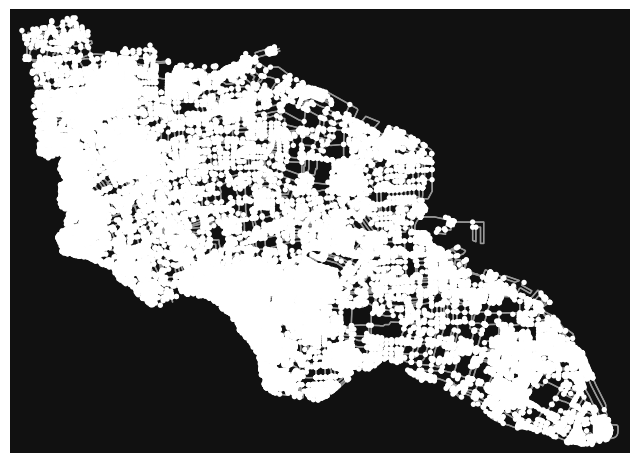

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [7]:
# Define the place
place_name = "Nantong, Jiangsu, China"
graph = ox.graph_from_place(place_name, network_type='bike') 

# Visualize the street network
ox.plot_graph(ox.project_graph(graph))

In [5]:
# Get all nodes in the graph and pick 2400 random ones, for test use 100 first
all_nodes = list(graph.nodes)
random_nodes = random.sample(all_nodes, 100)

In [6]:
from tqdm import tqdm

# Calculate shortest paths and add progress bar
paths = []
node_pairs = list(combinations(random_nodes, 2))  # Prepare all combinations first
for (node1, node2) in tqdm(node_pairs, desc="Calculating shortest paths"):
    try:
        length = nx.shortest_path_length(graph, node1, node2, weight='length')
        paths.append((node1, node2, length))
    except nx.NetworkXNoPath:
        continue  # Skip if no path exists

# Convert to DataFrame
df_paths = pd.DataFrame(paths, columns=['Start', 'End', 'Length'])

Calculating shortest paths: 100%|██████████| 4950/4950 [11:21<00:00,  7.26it/s]


In [4]:
# df_paths.to_csv('df_paths_100.csv', index=False)
# read saved graph paths

df_paths = pd.read_csv('df_paths_100.csv')

In [5]:
df_paths.head()

Start         End         Length
0  9035535216  7007456682   55465.432090
1  9035535216  6411257077  122251.471131
2  9035535216  2744167688   29209.381505
3  9035535216  4662951474   60463.553219
4  9035535216  7640379218   10801.981783

In [10]:
# Define the scenarios
scenarios = [
    ('winter', 'daytime'),
    ('winter', 'nighttime'),
    ('summer', 'daytime'),
    ('summer', 'nighttime')
]

# Demand levels might be affected by the scenario
base_demand = {
    'winter': {'daytime': 80, 'nighttime': 50},
    'summer': {'daytime': 120, 'nighttime': 70}
}

In [11]:
def simulate_demand(graph, season, time_of_day):
    demand = {}
    for node in graph.nodes:
        degree = len(list(graph.neighbors(node)))  # Simple proxy for density
        base = base_demand[season][time_of_day]
        density_factor = degree / 10  # Example: increase demand by 10% per connection beyond the first
        demand[node] = base + base * density_factor
    return demand

demand_data = {}
for season, time_of_day in scenarios:
    demand_data[(season, time_of_day)] = simulate_demand(graph, season, time_of_day)

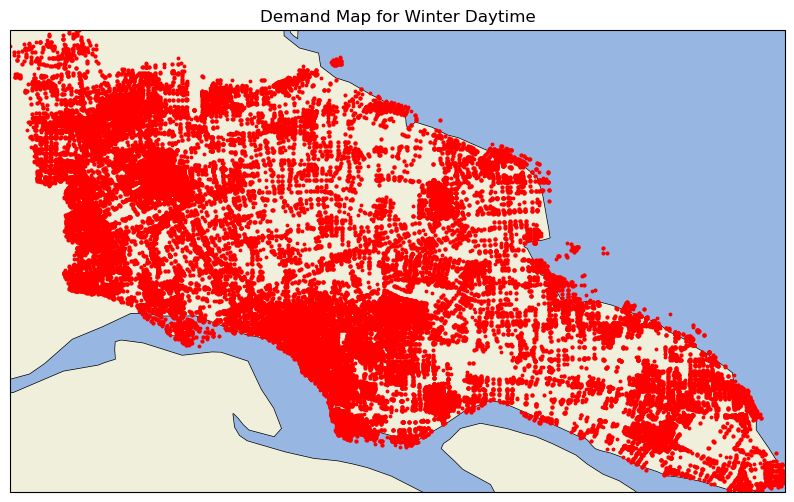

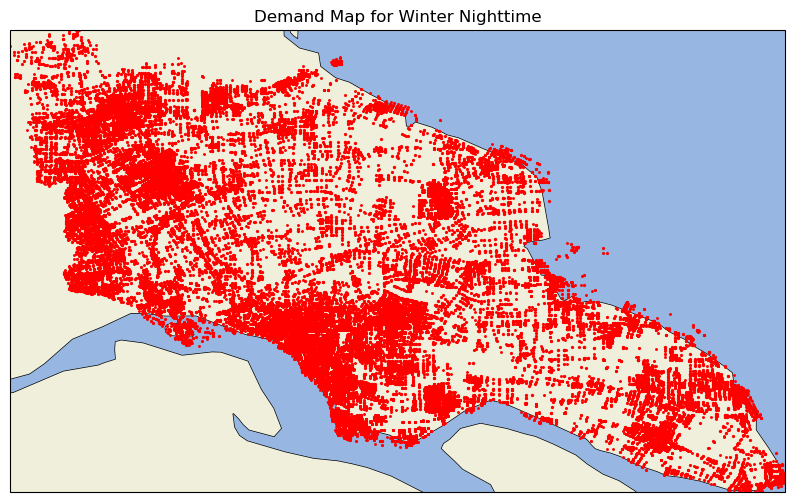

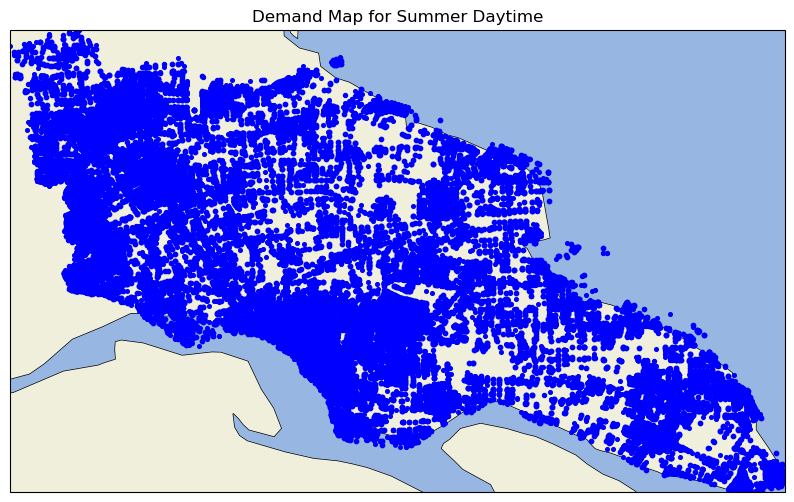

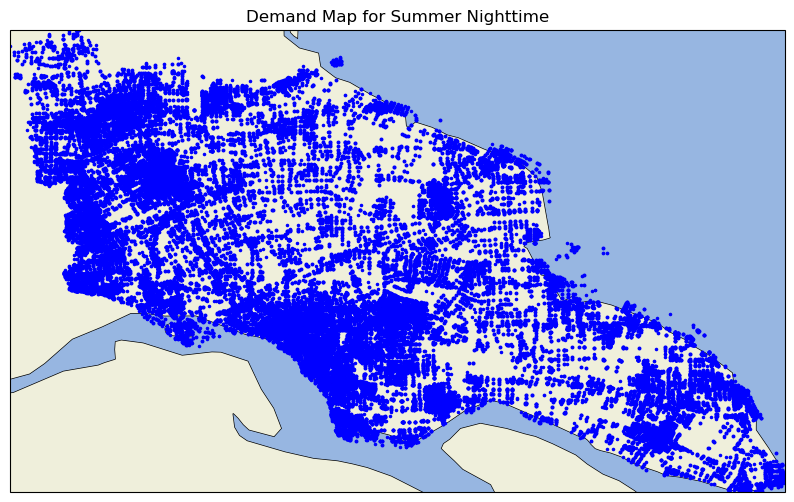

In [12]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import networkx as nx

def plot_scenario_demands(graph, demand_data, scenario):
    # Setup the map projection and figure
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([
        min(node['x'] for node in graph.nodes.values()),  # min longitude
        max(node['x'] for node in graph.nodes.values()),  # max longitude
        min(node['y'] for node in graph.nodes.values()),  # min latitude
        max(node['y'] for node in graph.nodes.values())  # max latitude
    ], crs=ccrs.PlateCarree())

    # Add geographic features
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)

    # Plotting nodes based on demand
    demands = demand_data[scenario]
    for node, demand in demands.items():
        ax.plot(graph.nodes[node]['x'], graph.nodes[node]['y'], 'o', markersize=demand / 50,  # Scale size as needed
                color='red' if scenario[0] == 'winter' else 'blue',  # Color code by season
                transform=ccrs.Geodetic())

    plt.title(f'Demand Map for {scenario[0].capitalize()} {scenario[1].capitalize()}')
    plt.show()

scenarios = [('winter', 'daytime'), ('winter', 'nighttime'), ('summer', 'daytime'), ('summer', 'nighttime')]
for scenario in scenarios:
    plot_scenario_demands(graph, demand_data, scenario)

In [25]:
import folium

def create_demand_map(graph, demands, title):
    # Get the geographic center of the graph for the initial map focus
    center_lat = sum(node['y'] for node in graph.nodes.values()) / len(graph.nodes)
    center_lon = sum(node['x'] for node in graph.nodes.values()) / len(graph.nodes)
    
    # Create the Folium map
    m = folium.Map(location=[center_lat, center_lon], zoom_start=13, tiles='cartodbpositron')
    
    # Add a marker for each node in the demand data
    for node, demand in demands.items():
        node_lat = graph.nodes[node]['y']
        node_lon = graph.nodes[node]['x']
        folium.CircleMarker(
            location=(node_lat, node_lon),
            radius=demand / 100,  # Adjust radius scaling to suit your data range and preference
            color='blue', fill=True, fill_color='blue',
            popup=f'Node: {node}, Demand: {demand}'
        ).add_to(m)
    
    # Save or show the map
    m.save(f'{title}.html')
    return m

# Generate a map for each scenario
for (season, time_of_day), demands in demand_data.items():
    map_title = f'{season.capitalize()} {time_of_day.capitalize()} Demand'
    create_demand_map(graph, demands, map_title)

## Week 2

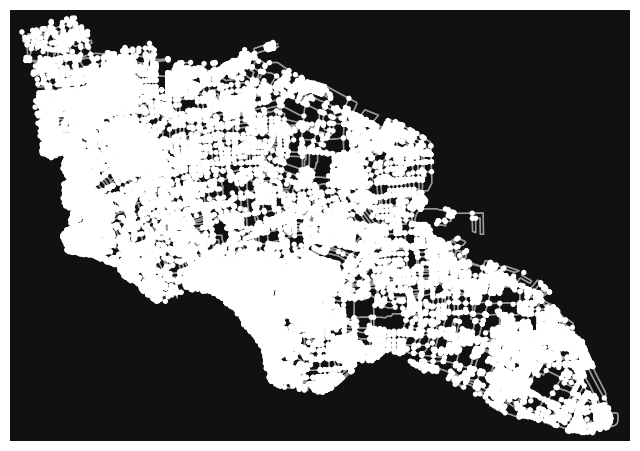

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [14]:
ox.plot_graph(graph)

In [15]:
# Get all nodes in the graph and pick 100 random ones
all_nodes = list(graph.nodes())
random_nodes = random.sample(all_nodes, 100)

# Simulate fixed demand at these nodes
demands = {node: np.random.randint(5, 15) for node in random_nodes}  # Random demand between 5 and 15 units

In [16]:
# Divide nodes among 10 delivery personnel
delivery_personnel = {i: [] for i in range(10)}
for i, node in enumerate(random_nodes):
    delivery_personnel[i % 10].append(node)

c:\ProgramData\anaconda3\envs\ra-route_network\Lib\site-packages\osmnx\plot.py:348: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(od_x, od_y, s=orig_dest_size, c=route_color, alpha=route_alpha, edgecolor="none")


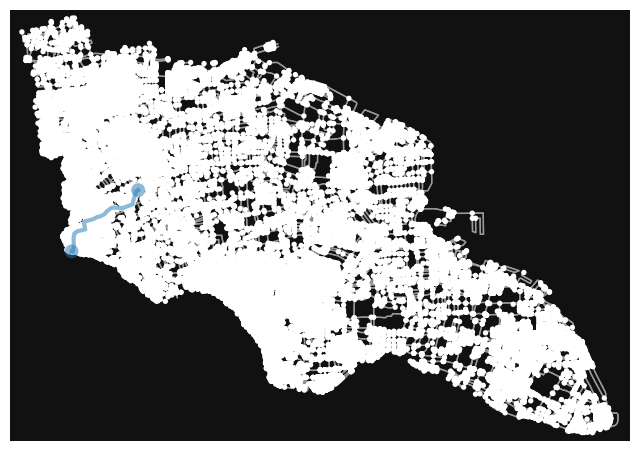

In [17]:
fig, ax = ox.plot_graph(graph, show=False, close=False)

# Plot each delivery route
for person, nodes in delivery_personnel.items():
    for path in combinations(nodes, 2):
        try:
            shortest_path = nx.shortest_path(graph, path[0], path[1], weight='length')
            ox.plot_graph_route(graph, shortest_path, ax=ax, route_color=plt.cm.tab10(person % 10), route_linewidth=3)
        except nx.NetworkXNoPath:
            continue

plt.show()

In [21]:
# Create a base map
m = folium.Map(location=[32.01, 120.85], zoom_start=13, tiles='cartodbpositron')

# Plot nodes and routes
for person, nodes in delivery_personnel.items():
    color = plt.cm.tab10(person % 10)
    for path in combinations(nodes, 2):
        try:
            shortest_path = nx.shortest_path(graph, path[0], path[1], weight='length')
            points = [(graph.nodes[p]['y'], graph.nodes[p]['x']) for p in shortest_path]
            folium.PolyLine(points, color=color, weight=2.5, opacity=1).add_to(m)
        except nx.NetworkXNoPath:
            continue

    # Add node markers
    for node in nodes:
        folium.CircleMarker(
            location=(graph.nodes[node]['y'], graph.nodes[node]['x']),
            radius=5,
            popup=f'Node: {node}<br>Demand: {demands[node]}',
            color=color,
            fill=True,
            fill_color=color
        ).add_to(m)

m.save('delivery_routes.html')
m

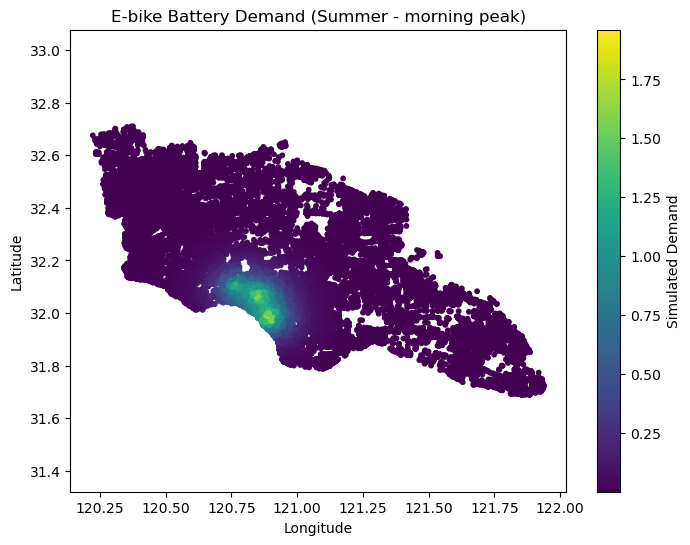

In [22]:
import osmnx as ox
import networkx as nx
import numpy as np

# 1. Load Nantong bike-accessible graph and get parking nodes (by their coordinates)
place_name = "Nantong, China"
G = ox.graph_from_place(place_name, network_type='bike')  # bike-accessible street network
# Convert graph nodes to GeoDataFrame to access coordinates easily (if needed)
nodes, edges = ox.graph_to_gdfs(G)
# Use node coordinates as parking spot locations
parking_nodes = nodes[['y', 'x']].copy()  # lat = y, lon = x for each node

# 2. Define anchor locations for high demand (train stations, city center, etc.)
# If specific anchor data is unavailable, we fall back to city center as an anchor.
anchor_points = {
    "City Center": {"coords": (31.981, 120.894), "weight": 1.0},               # Nantong city center&#8203;:contentReference[oaicite:5]{index=5}
    "Nantong Railway Station": {"coords": (32.0702, 120.8560), "weight": 0.8},  # major train station north of center&#8203;:contentReference[oaicite:6]{index=6}
    "Nantong West Station": {"coords": (32.1036, 120.7611), "weight": 0.6}      # another rail station on west side&#8203;:contentReference[oaicite:7]{index=7}
    # (Add more anchors like universities or malls if known, with appropriate weights)
}

# 3. Set up the spatial decay function parameters
decay_distance = 5000.0  # decay scale in meters (e.g., ~5 km for demand to drop significantly)

# Helper function: compute great-circle distance (meters) between two lat-lon points
def haversine_distance(lat1, lon1, lat2, lon2):
    # Earth radius in meters
    R = 6371000  
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlam = np.radians(lon2 - lon1)
    # Haversine formula
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlam/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# 4. Define time-of-day and seasonal demand multipliers
time_of_day_factors = {
    "early_morning": 0.5,  # late night/early morning (very low usage)
    "morning_peak": 1.5,   # morning rush hour (high usage)
    "midday": 1.0,         # midday (baseline)
    "evening_peak": 1.3,   # evening rush hour (moderately high)
    "night": 0.6           # late evening (reduced usage)
}
seasonal_factors = {
    "winter": 0.7,   # cold season (lower demand)
    "spring": 1.0,   # mild weather (baseline)
    "summer": 1.2,   # warm season (higher demand)
    "autumn": 0.9    # fall (slightly less than spring)
}

# Choose a scenario for simulation (e.g., summer morning peak)
time_period = "morning_peak"
season = "summer"
time_factor = time_of_day_factors[time_period]
season_factor = seasonal_factors[season]

# 5. Compute demand at each parking node
demand_values = [] 
for node_id, node in parking_nodes.iterrows():
    lat, lon = node['y'], node['x']  # latitude and longitude of the parking spot
    # Base demand from spatial decay (sum contributions from all anchors)
    base_demand = 0.0
    for anc_name, anc in anchor_points.items():
        anc_lat, anc_lon = anc["coords"]
        dist = haversine_distance(lat, lon, anc_lat, anc_lon)
        # Spatial decay: higher demand near anchor, decays with distance
        base_demand += anc["weight"] * np.exp(-dist / decay_distance)
    # Apply time-of-day and seasonal multipliers
    demand = base_demand * time_factor * season_factor
    demand_values.append(demand)

# Attach demand values to the parking_nodes DataFrame for reference
parking_nodes[f"demand_{season}_{time_period}"] = demand_values

# Visualize spatial demand distribution
plt.figure(figsize=(8,6))
plt.scatter(parking_nodes['x'], parking_nodes['y'], 
            c=parking_nodes[f"demand_{season}_{time_period}"], cmap="viridis", s=10)
plt.colorbar(label="Simulated Demand")
plt.title(f"E-bike Battery Demand ({season.capitalize()} - {time_period.replace('_', ' ')})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis("equal")  # equal scale for lat/lon axes to preserve spatial proportions
plt.show()